In [13]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns


torch.cuda.set_device(0) 


def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018"

In [14]:
X = np.load('./data/big_numpy_datasets/%s_signitured.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
# get diseases that exist in more than 0.5 percent of the samples
y=y[y.columns[y.sum()>(0.005*y.shape[0])]]
y.sum()
y.reset_index(drop=True)

KeyError: "None of [Index(['Dx', 'SNOMED CT Code'], dtype='object')] are in the [columns]"

In [3]:
# df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
# y = snomedConvert(y)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


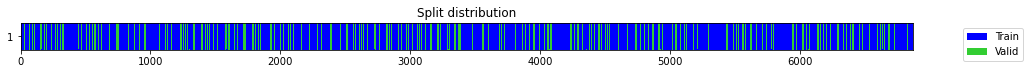

epoch,train_loss,valid_loss,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.380507,0.309444,0.648388,0.369262,0.972923,0.470178,00:27
1,0.270620,0.243083,0.809311,0.394578,0.987450,0.529578,00:28
2,0.219910,0.201381,0.829941,0.525242,0.985470,0.642829,00:28
3,0.189809,0.188887,0.837345,0.539982,0.985765,0.655963,00:27
4,0.174624,0.210620,0.775949,0.529049,0.979312,0.628683,00:28
5,0.160609,0.183698,0.815570,0.567582,0.982608,0.669025,00:27
6,0.152487,0.168634,0.793558,0.637901,0.977480,0.706812,00:27
7,0.144104,0.158466,0.860180,0.608648,0.986571,0.712497,00:27
8,0.137756,0.168692,0.818903,0.636046,0.980999,0.715640,00:27
9,0.132133,0.150226,0.848107,0.666494,0.983858,0.746073,00:27


In [ ]:
def objective(trial:optuna.Trial):    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     
    tfms = []
    depth = trial.suggest_int('depth', 8,14,step=1) # search through all integer values between 3 and 9 with 3 increment steps
    kernel_size = trial.suggest_int('kernel_size', 80,160,step=10) # search through all integer values between 3 and 9 with 3 increment steps
    scale = trial.suggest_uniform('scale', 0.1,0.6) 
    max_length = trial.suggest_int("max_length",3000,8000,step = 1000)
#     use_loss_weights = trial.suggest_categorical("loss_weights", [True,False]) 
    batch_tfms = [
        tfs.Normalize(),
        tfs.Scale(scale_factor=scale)
     ]

    
    tfms = [None,TSMultiLabelClassification()]
    splits = get_splits(y.to_numpy(), valid_size=0.25, stratify=False, random_state=23, shuffle=True)
    dsets = TSDatasets(X.astype(float)[:,:,0:max_length], y_multi, tfms=tfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics = [precision_multi, recall_multi, specificity_multi, F1_multi] 
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=depth,ks=kernel_size)
    
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(),
                    opt_func = wrap_optimizer(torch.optim.Adam,),
                    cbs=FastAIPruningCallback(trial,monitor="F1_multi"))
#     learn.recorder.silent = True 
    learn.fit_one_cycle(300, lr_max=0.01)
    # get best f1 every scored
    f1 = np.max(np.array(learn.recorder.values)[:,-1])
    # save model if u want
#     if f1>0.84:
#         PATH = Path('./models/inception_hyperparam_%s.pkl'%f1)
#         PATH.parent.mkdir(parents=True, exist_ok=True)
#         learn.export(PATH)
    # Return the objective value
    return f1 # return the f1 value and try to maximize it

study_name = "hyperparam_search_%s"%DATASET_NAME # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
                            pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(),patience=25),
                           sampler=optuna.samplers.RandomSampler())

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study.optimize(objective, n_trials=100,)